In [10]:
import cv2
import numpy as np



In [3]:
import tensorflow as tf

In [67]:
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras import backend as K
import numpy as np

def grad_cam(image_path, target_class, model, conv_name):
    @tf.function
    def compute_grad_cam(x, target_class, model, conv_name):
        # Get last convolutional layer
        last_conv_layer = model.get_layer(conv_name)  # Model's last conv layer name

        # Create a new model to get the output of the last conv layer
        last_conv_model = tf.keras.Model(model.inputs, last_conv_layer.output)

        # Get output of the last conv layer
        last_conv_output = last_conv_model(x, training=False)

        # Create a placeholder tensor with the shape of the last conv layer's activation
        output_tensor = tf.compat.v1.placeholder(dtype=tf.float32, shape=last_conv_output.shape)

        # Resize the output tensor to match the shape of the last conv layer's activation
        resized_output_tensor = tf.image.resize(output_tensor, last_conv_output.shape[1:3])

        # Define functions for calculating gradients
        with tf.GradientTape() as tape:
            predictions = model(x, training=False)
            output = predictions[:, target_class]
            print("Output shape:", output.shape)
            print("Resized output tensor shape:", resized_output_tensor.shape)
            grads = tape.gradient(output, resized_output_tensor)
            print("Gradients:", grads)
            if grads is None:
                print("WARNING: Gradients are None!")
                return None  # Return None if gradients are None
            else:
                pooled_grads = K.mean(grads, axis=(0, 1, 2))
                pooled_grads_value = pooled_grads.numpy()
                for i in range(pooled_grads.shape[0]):
                    last_conv_output[:, :, i] *= pooled_grads_value[i]

                heatmap = np.mean(last_conv_output, axis=-1)
                heatmap = np.maximum(heatmap, 0)
                heatmap /= np.max(heatmap)

        return heatmap

    # Load and preprocess image using TensorFlow's load_img
    img = load_img(image_path)
    img = img.resize((299, 299))  # Resize to match InceptionV3 input size
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    heatmap = compute_grad_cam(x, target_class, model, conv_name)
    return heatmap


def visualize_grad_cam(image_path, target_class, model, conv_name):
    # Get grad_cam result
    grad_cam_result = grad_cam(image_path, target_class, model, conv_name)

    if grad_cam_result is None:
        print("Grad-CAM result is None. Cannot visualize.")
        return

    # Read original image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (299, 299))  # Resize to match heatmap dimensions

    # Rescale heatmap to [0, 255] for visualization
    heatmap = np.uint8(255 * grad_cam_result)

    # Apply heatmap onto image using jet colormap
    jet_colormap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    composite_image = cv2.addWeighted(img, 0.5, jet_colormap, 0.5, 0)

    # Display visualized image
    cv2.imshow("Grad-CAM Visualization", composite_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()





In [61]:
from tensorflow.keras.applications import InceptionV3

# Load InceptionV3 model pretrained on ImageNet
model = InceptionV3(weights='imagenet', include_top=True)
model.trainable = False  # Set the model to inference mode

image_path = "/Users/faizahkureshi/Desktop/Capstone Project/download.jpeg"
target_class = 71  

# Print layer names
for layer in model.layers:
    print(layer.name)


input_layer_12
conv2d_1128
batch_normalization_1128
activation_1128
conv2d_1129
batch_normalization_1129
activation_1129
conv2d_1130
batch_normalization_1130
activation_1130
max_pooling2d_48
conv2d_1131
batch_normalization_1131
activation_1131
conv2d_1132
batch_normalization_1132
activation_1132
max_pooling2d_49
conv2d_1136
batch_normalization_1136
activation_1136
conv2d_1134
conv2d_1137
batch_normalization_1134
batch_normalization_1137
activation_1134
activation_1137
average_pooling2d_108
conv2d_1133
conv2d_1135
conv2d_1138
conv2d_1139
batch_normalization_1133
batch_normalization_1135
batch_normalization_1138
batch_normalization_1139
activation_1133
activation_1135
activation_1138
activation_1139
mixed0
conv2d_1143
batch_normalization_1143
activation_1143
conv2d_1141
conv2d_1144
batch_normalization_1141
batch_normalization_1144
activation_1141
activation_1144
average_pooling2d_109
conv2d_1140
conv2d_1142
conv2d_1145
conv2d_1146
batch_normalization_1140
batch_normalization_1142
batch_n

In [69]:
#conv_name='conv2d_1033'
#conv_name='conv2d_1127'
conv_name='mixed10'
visualize_grad_cam(image_path, target_class,model,conv_name)

Output shape: (1,)
Resized output tensor shape: (1, 8, 8, 2048)
Gradients: None
Grad-CAM result is None. Cannot visualize.


In [66]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, show_factorization_on_image
from torchvision.models import resnet50
from PIL import Image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image as keras_image

def category_name_to_index(model, category_name):
    name_to_index = dict((v, k) for k, v in model.config.id2label.items())
    return name_to_index[category_name]
model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]

rgb_img="/Users/faizahkureshi/Desktop/Capstone Project/download.jpeg"
# Step 1: Load the image
image_path = "/Users/faizahkureshi/Desktop/Capstone Project/download.jpeg"
image = Image.open(image_path)

# Step 2: Preprocess the image
resnet_input_size = (224, 224)  # ResNet50 input size
image = image.resize(resnet_input_size)  # Resize the image
image_array = keras_image.img_to_array(image)  # Convert PIL Image to numpy array
image_array = preprocess_input(image_array)  # Preprocess the image for ResNet50

# Step 3: Convert the preprocessed image array into a tensor
input_tensor = keras_image.img_to_array(image_array)
input_tensor = np.expand_dims(input_tensor, axis=0)  # Add batch dimension

# The input tensor is now ready to be used as input to the ResNet50 model

# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(category_name_to_index(model, "Scorpion"))]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

 11%|█         | 10.9M/97.8M [00:12<01:38, 923kB/s] 


KeyboardInterrupt: 

GRAD-CAM HUGGING FACE

In [2]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import transforms
from datasets import load_dataset
from pytorch_grad_cam import run_dff_on_image, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import cv2
import torch
from typing import List, Callable, Optional
import matplotlib.pyplot as plt


image_path = "/Users/faizahkureshi/Desktop/Capstone Project/Screenshot 2024-03-26 at 9.32.54 PM.png"
image = Image.open(image_path)
img_tensor = transforms.ToTensor()(image)

""" Model wrapper to return a tensor"""
class ImageToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(ImageToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits

""" Translate the category name to the category index.
    Some models aren't trained on Imagenet but on even larger datasets,
    so we can't just assume that 761 will always be remote-control.

"""
def category_name_to_index(model, category_name):
    name_to_index = dict((v, k) for k, v in model.config.id2label.items())
    return name_to_index[category_name]
    
""" Helper function to run GradCAM on an image and create a visualization.
    (note to myself: this is probably useful enough to move into the package)
    If several targets are passed in targets_for_gradcam,
    e.g different categories,
    a visualization for each of them will be created.
    
"""
def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          targets_for_gradcam: List[Callable],
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.nn.Module=img_tensor,
                          input_image: Image=image,
                          method: Callable=GradCAM):
    with method(model=ImageToTensorModelWrapper(model),
                 target_layers=[target_layer],
                 reshape_transform=reshape_transform) as cam:

        # Replicate the tensor for each of the categories we want to create Grad-CAM for:
        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)

        batch_results = cam(input_tensor=repeated_tensor,
                            targets=targets_for_gradcam)
        results = []
        for grayscale_cam in batch_results:
            visualization = show_cam_on_image(np.float32(input_image)/255,
                                              grayscale_cam,
                                              use_rgb=True)
            # Make it weight less in the notebook:
            visualization = cv2.resize(visualization,
                                       (visualization.shape[1]//2, visualization.shape[0]//2))
            results.append(visualization)
        return np.hstack(results)
    
    
def print_top_categories(model, img_tensor, top_k=5):
    logits = model(img_tensor.unsqueeze(0)).logits
    indices = logits.cpu()[0, :].detach().numpy().argsort()[-top_k :][::-1]
    for i in indices:
        print(f"Predicted class {i}: {model.config.id2label[i]}")

In [4]:
from transformers import ResNetForImageClassification
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

# We will show GradCAM for the "Egyptian Cat" and the 'Remote Control" categories:
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "Egyptian cat")),
                       ClassifierOutputTarget(category_name_to_index(model, "remote control, remote"))]

# The last layer in the Resnet Encoder:
target_layer = model.resnet.encoder.stages[-1].layers[-1]


In [ ]:
display(Image.fromarray(run_dff_on_image(model=model,
                          target_layer=target_layer,
                          classifier=model.classifier,
                          img_pil=image,
                          img_tensor=img_tensor,
                          reshape_transform=None,
                          n_components=4,
                          top_k=2)))

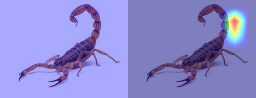

In [64]:
display(Image.fromarray(run_grad_cam_on_image(model=model,
                      target_layer=target_layer,
                      targets_for_gradcam=targets_for_gradcam,
                      reshape_transform=None)))

In [34]:
print_top_categories(model, img_tensor)

Predicted class 71: scorpion
Predicted class 79: centipede
Predicted class 111: nematode, nematode worm, roundworm
Predicted class 41: whiptail, whiptail lizard
Predicted class 78: tick


In [17]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import transforms
from datasets import load_dataset
from pytorch_grad_cam import run_dff_on_image, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import cv2
import torch
from typing import List, Callable, Optional
dataset = load_dataset("/Users/faizahkureshi/Desktop/Capstone Project/dataset")
image = dataset["test"]["image"][0]
img_tensor = transforms.ToTensor()(image)
print(img_tensor.shape)


""" Model wrapper to return a tensor"""
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits

""" Translate the category name to the category index.
    Some models aren't trained on Imagenet but on even larger datasets,
    so we can't just assume that 761 will always be remote-control.

"""
def category_name_to_index(model, category_name):
    name_to_index = dict((v, k) for k, v in model.config.id2label.items())
    return name_to_index[category_name]
    
""" Helper function to run GradCAM on an image and create a visualization.
    (note to myself: this is probably useful enough to move into the package)
    If several targets are passed in targets_for_gradcam,
    e.g different categories,
    a visualization for each of them will be created.
    
"""
def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          targets_for_gradcam: List[Callable],
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.nn.Module=img_tensor,
                          input_image: Image=image,
                          method: Callable=GradCAM):
    with method(model=HuggingfaceToTensorModelWrapper(model),
                 target_layers=[target_layer],
                 reshape_transform=reshape_transform) as cam:

        # Replicate the tensor for each of the categories we want to create Grad-CAM for:
        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)

        batch_results = cam(input_tensor=repeated_tensor,
                            targets=targets_for_gradcam)
        results = []
        for grayscale_cam in batch_results:
            visualization = show_cam_on_image(np.float32(input_image)/255,
                                              grayscale_cam,
                                              use_rgb=True)
            # Make it weight less in the notebook:
            visualization = cv2.resize(visualization,
                                       (visualization.shape[1]//2, visualization.shape[0]//2))
            results.append(visualization)
        return np.hstack(results)
    
    
def print_top_categories(model, img_tensor, top_k=5):
    logits = model(img_tensor.unsqueeze(0)).logits
    indices = logits.cpu()[0, :].detach().numpy().argsort()[-top_k :][::-1]
    for i in indices:
        print(f"Predicted class {i}: {model.config.id2label[i]}")

torch.Size([4, 1132, 782])


In [ ]:
from transformers import ResNetForImageClassification
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

# We will show GradCAM for the "Egyptian Cat" and the 'Remote Control" categories:
targets_for_gradcam = [ClassifierOutputTarget(category_name_to_index(model, "Egyptian cat"))]

# The last layer in the Resnet Encoder:
target_layer = model.resnet.encoder.stages[-1].layers[-1]

display(Image.fromarray(run_dff_on_image(model=model,
                          target_layer=target_layer,
                          classifier=model.classifier,
                          img_pil=image,
                          img_tensor=img_tensor,
                          reshape_transform=None,
                          n_components=4,
                          top_k=2)))


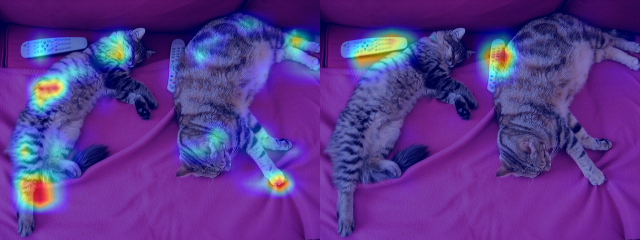

Predicted class 761: remote control, remote
Predicted class 282: tiger cat
Predicted class 285: Egyptian cat
Predicted class 281: tabby, tabby cat
Predicted class 721: pillow


In [8]:
display(Image.fromarray(run_grad_cam_on_image(model=model,
                      target_layer=target_layer,
                      targets_for_gradcam=targets_for_gradcam,
                      reshape_transform=None)))
print_top_categories(model, img_tensor)

In [1]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# define a 1 image dataset
dataset = datasets.ImageFolder(root='/Users/faizahkureshi/Desktop/Capstone Project/dataset', transform=transform)

/Users/faizahkureshi/anaconda3/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 1.6 MB/s eta 0:00:0000:0100:01
